In [49]:
from myclasses.sql_executor import SQLExecutor

if __name__ == "__main__":
    # Create an instance of SQLExecutor
    sql_executor = SQLExecutor()

    # Example SQL query
    query = """
        SELECT * FROM Master
        """

    # Execute the query and get the result as a DataFrame
    costreport_df = sql_executor.execute_query(query)

costreport_df.info()

df = costreport_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97386 entries, 0 to 97385
Data columns (total 67 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   prov_id                           97386 non-null  object 
 1   fiscal_year                       97386 non-null  int64  
 2   ownership                         97386 non-null  object 
 3   tot_days                          97386 non-null  float64
 4   tot_days_title_v                  97386 non-null  float64
 5   tot_days_title_xviii              97386 non-null  float64
 6   tot_days_title_xix                97386 non-null  float64
 7   num_beds                          97386 non-null  float64
 8   tot_bed_days_avail                97386 non-null  float64
 9   snf_num_beds                      97386 non-null  float64
 10  snf_admis_tot                     97386 non-null  float64
 11  snf_avg_stay_len_title_tot        97386 non-null  float64
 12  snf_

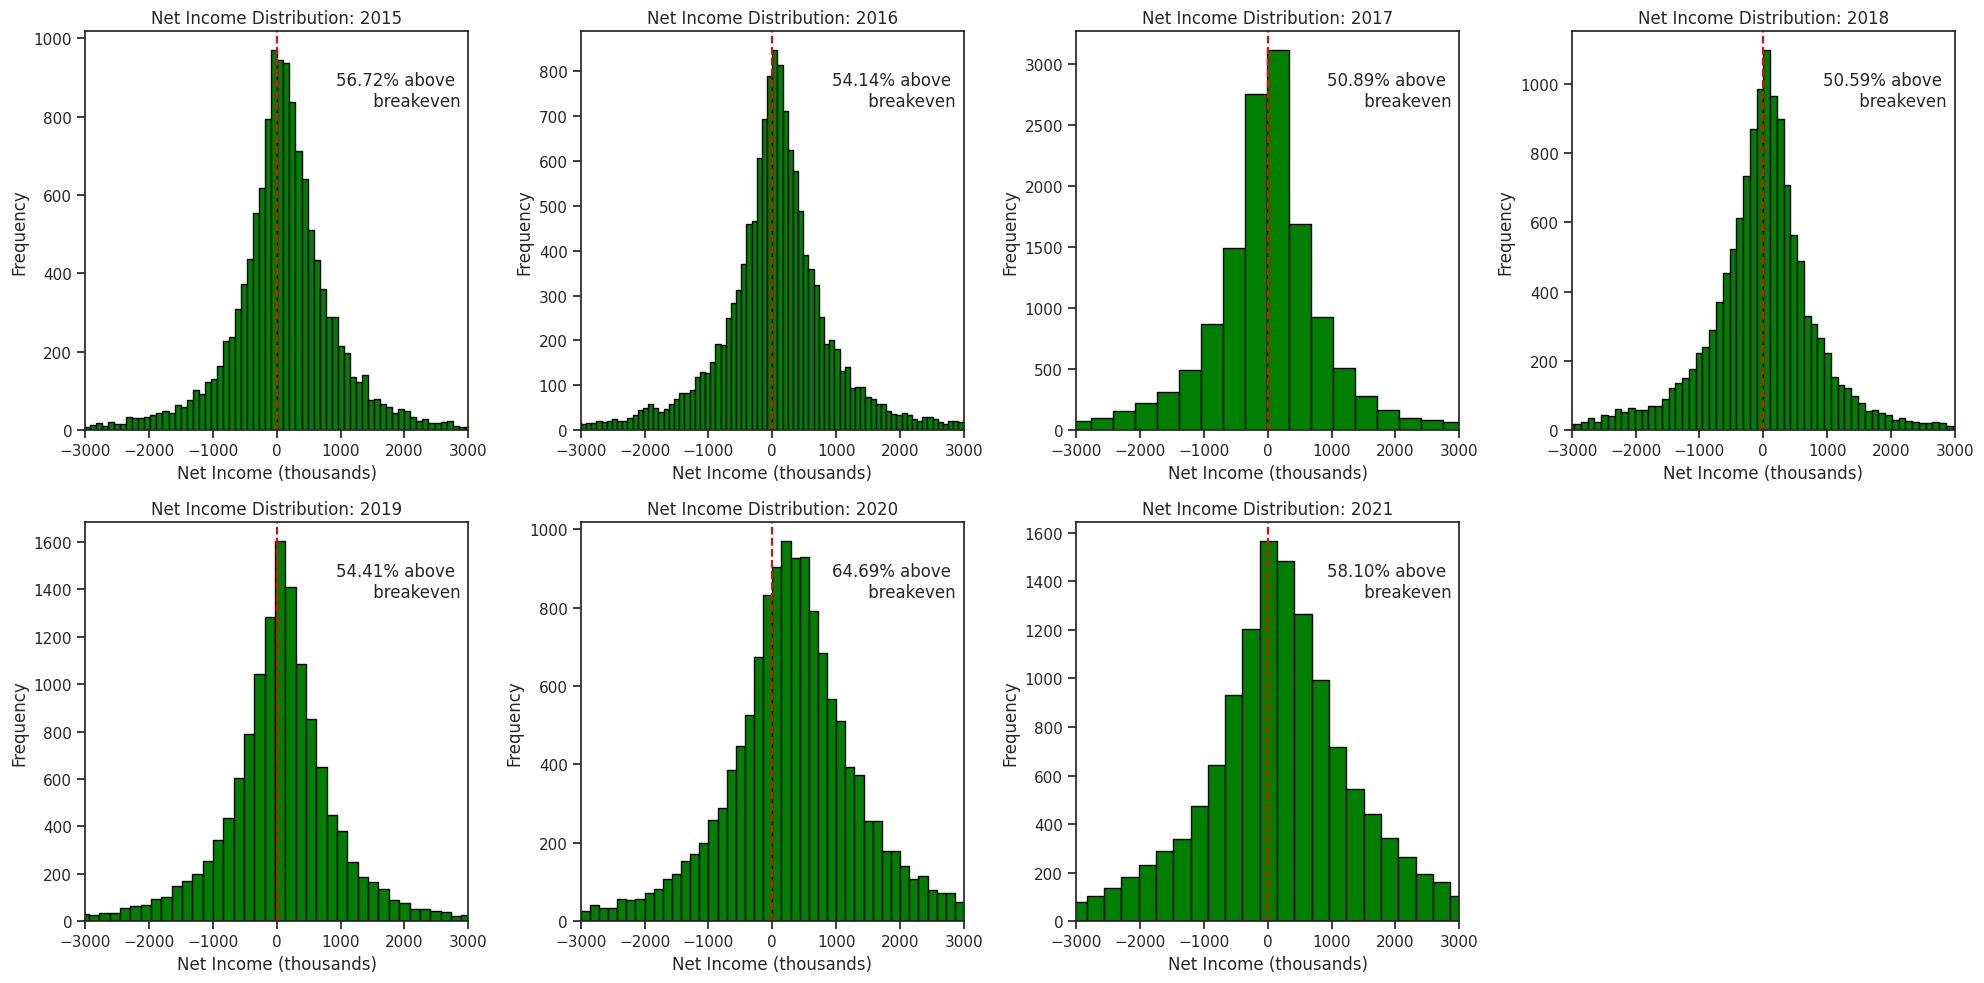

In [50]:
import matplotlib.pyplot as plt

net_income = costreport_df[['fiscal_year','net_income']]
net_income_dict = {}

for fiscal_year, group_data in net_income.groupby('fiscal_year'):

    # Extract net_income values and convert to a list
    net_income_dict[fiscal_year] = group_data['net_income'].dropna().tolist()


# Filter out fiscal year 2022
net_income_filtered_dict = {fiscal_year: net_income_list for fiscal_year, net_income_list in net_income_dict.items() if fiscal_year != 2022}

# Create a figure and subplots
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))

# Iterate over the filtered dictionary items and enumerate to get both index and data
for idx, (fiscal_year, net_income_list) in enumerate(net_income_filtered_dict.items()):
    if idx >= 8:  # Limit to the first 8 fiscal years
        break
    
    # Divide net income values by a thousand
    net_income_list = [income / 1000 for income in net_income_list]
    
    # Calculate the position in the grid
    row = idx // 4
    col = idx % 4
    
    # Create a histogram for the current fiscal year in the appropriate subplot
    axs[row, col].hist(net_income_list, bins=1000, color='green', edgecolor='black')
    axs[row, col].set_title(f'Net Income Distribution: {fiscal_year}')
    axs[row, col].set_xlabel('Net Income (thousands)')
    axs[row, col].set_ylabel('Frequency')
    
    # Center x-axis at 0
    axs[row, col].set_xlim(-3000, 3000)
    
    # Draw dotted line at x=0
    axs[row, col].axvline(x=0, color='red', linestyle='--')
    axs[row, col].grid(False)
    
    # Calculate percentage of data above 0
    data_above_zero = sum(x > 0 for x in net_income_list)
    total_data_points = len(net_income_list)
    percentage_above_zero = (data_above_zero / total_data_points) * 100
    
    # Annotate plot with percentage above 0
    axs[row, col].annotate(f"{percentage_above_zero:.2f}% above \n breakeven", xy=(0.98, 0.9), xycoords='axes fraction', ha='right', va='top')

# Set the 8th subplot as None (empty space)
axs[1, 3].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

plt.show()

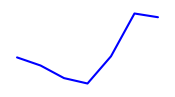

In [51]:
import numpy as np

# Calculate mean net income for each fiscal year
mean_net_income_by_year = {fiscal_year: np.mean(net_income_list) for fiscal_year, net_income_list in net_income_filtered_dict.items()}
years = list(mean_net_income_by_year.keys())
mean_incomes = list(mean_net_income_by_year.values())

# Plot the trend line only
plt.figure(figsize=(2, 1))
plt.plot(years, mean_incomes, color='blue', linewidth=1.5, label='Mean Income')
plt.xticks([])  # Hide x-axis ticks
plt.yticks([])  # Hide y-axis ticks
plt.gca().spines['top'].set_visible(False)  # Hide top spine
plt.gca().spines['right'].set_visible(False)  # Hide right spine
plt.gca().spines['bottom'].set_visible(False)  # Hide bottom spine
plt.gca().spines['left'].set_visible(False)  # Hide left spine
plt.legend().set_visible(False)  # Hide legend
plt.show()

/tmp/ipykernel_9298/3239483197.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2020["net_income_per_bed"] = df_2020["net_income"] / df_2020["num_beds"]


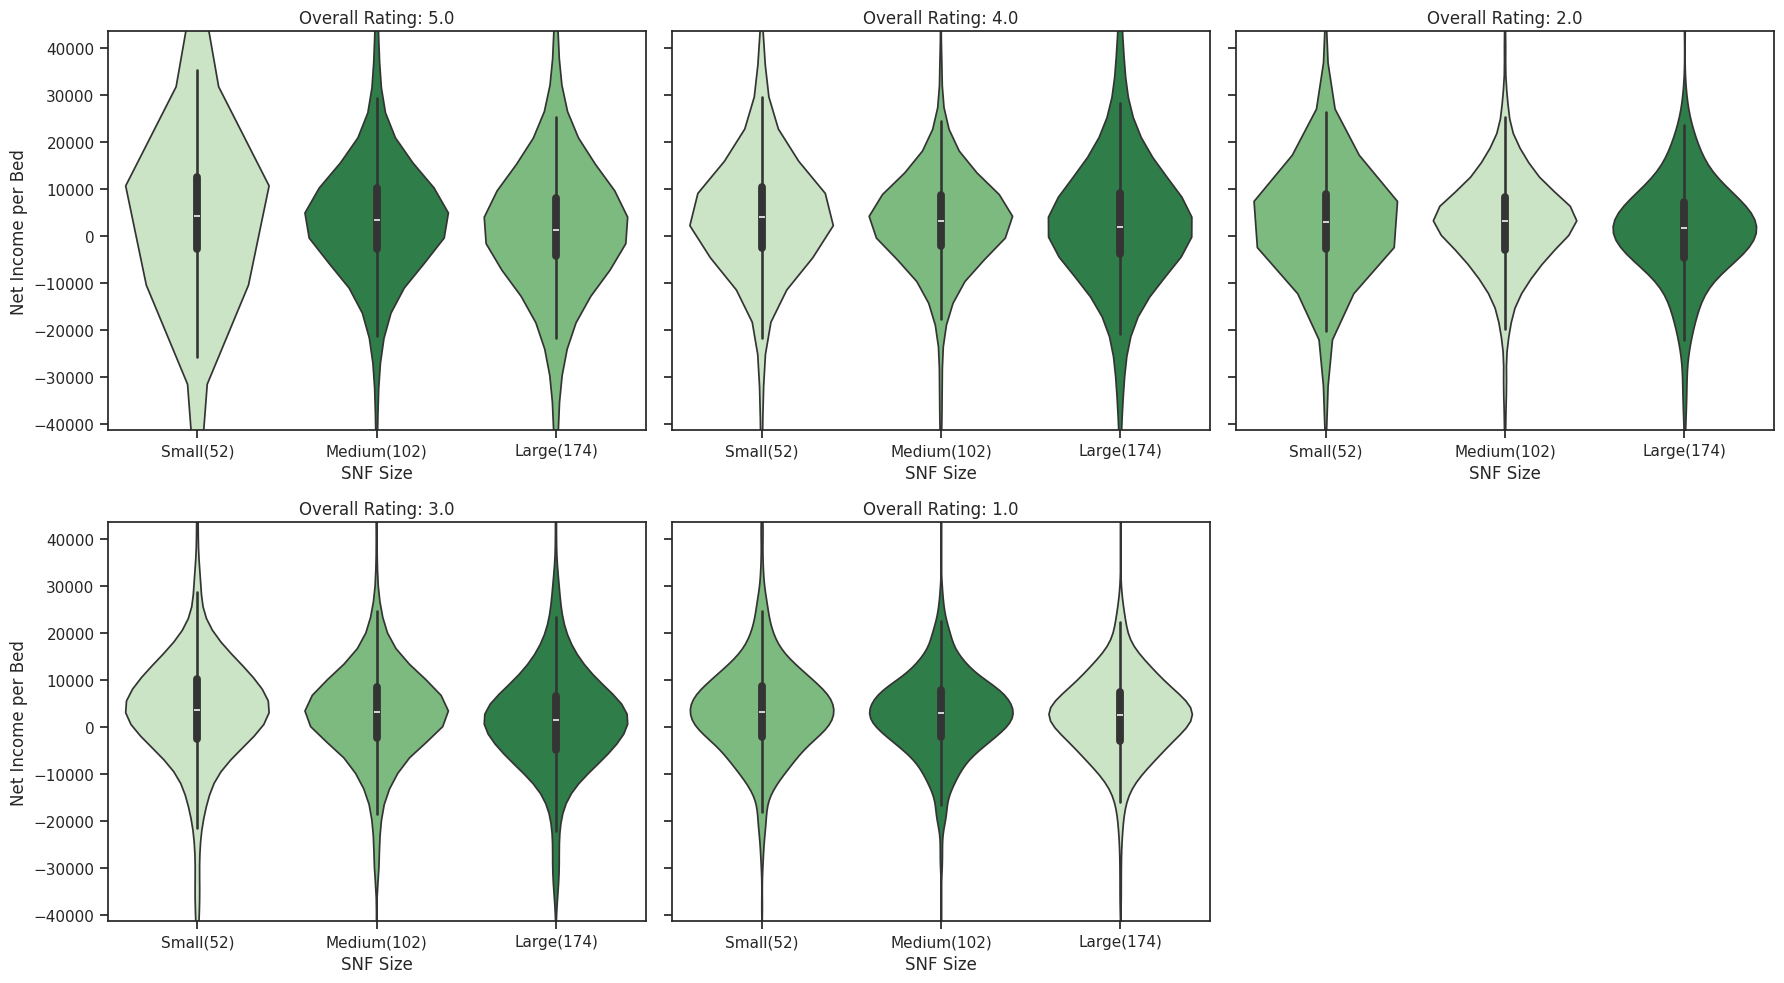

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
import math

sns.set_theme(style="ticks")

# Define a greenish color palette
greenish_palette = sns.color_palette("Greens", 3)

# Filter the DataFrame for fiscal year 2020
df_2020 = df.loc[df['fiscal_year'] == 2020]

# Calculate net income per bed for fiscal year 2020
df_2020["net_income_per_bed"] = df_2020["net_income"] / df_2020["num_beds"]

# Determine the number of unique ratings
unique_ratings = df["overall_rating"].unique()
num_ratings = len(unique_ratings)

# Calculate the number of rows required based on the number of ratings and desired columns
num_rows = math.ceil(num_ratings / 3)

# Define the order of SNF sizes
snf_size_order = ["Small(52)", "Medium(102)", "Large(174)"]

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(18, num_rows*5), sharey=True)

# Flatten the axes array if there's only one row
if num_rows == 1:
    axes = axes.reshape(1, -1)

# Iterate over ratings and create a violin plot for each
for i, rating in enumerate(unique_ratings):
    row = i // 3
    col = i % 3
    rating_df = df_2020[df_2020["overall_rating"] == rating]
    sns.violinplot(x="snf_size", y="net_income_per_bed", data=rating_df, ax=axes[row, col], hue="snf_size", palette=greenish_palette, legend=False, bw_method="silverman", cut=0, order=snf_size_order)
    axes[row, col].set_title(f"Overall Rating: {rating}")
    axes[row, col].set_xlabel("SNF Size")
    axes[row, col].set_ylabel("Net Income per Bed")
    
    # Set y-axis limits
    # Here you can adjust the limits according to your preference
    # This example sets the y-axis limits to the 5th and 95th percentiles of the data
    ylim_min = rating_df["net_income_per_bed"].quantile(0.001)
    ylim_max = rating_df["net_income_per_bed"].quantile(0.999)
    axes[row, col].set_ylim(ylim_min, ylim_max)

# Hide empty subplots
for i in range(num_ratings, num_rows*3):
    row = i // 3
    col = i % 3
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()


In [53]:
from myclasses.sql_executor import SQLExecutor

if __name__ == "__main__":
    # Create an instance of SQLExecutor
    sql_executor = SQLExecutor()

    # Example SQL query
    query = """
        SELECT * FROM CovidVax
        """

    # Execute the query and get the result as a DataFrame
    vax_df = sql_executor.execute_query(query)

vax_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30411 entries, 0 to 30410
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   prov_id                    30411 non-null  object
 1   prov_state                 30411 non-null  object
 2   pct_residents_primary_vax  30411 non-null  object
 3   pct_staff_primary_vax      30411 non-null  object
 4   last_update                30411 non-null  object
 5   pct_residents_todate_vax   15147 non-null  object
 6   pct_staff_todate_vax       15147 non-null  object
dtypes: object(7)
memory usage: 1.6+ MB


In [ ]:
df[]